In [1]:
import pandas as pd
import pickle
from scripts.interactive_search import *
import numpy as np
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
import colorsys
import matplotlib.pyplot as plt
from skimage import io
import json
import math
import time
from scipy.spatial.distance import cdist, pdist

In [2]:
# Change this function to select a different paper set
def read_metadata(path):
    df = pd.read_csv(path)
    df = df.astype({'abstract': 'str'})
    df = df[df['abstract'] != 'Unknown']
    df = df[df['abstract'] != 'nan']
    df = df[df['language'] == 'en']
    df = df[df['publish_time'].str[:4] == '2020']
    df = df.reset_index(drop=True)
    df = df[:1000]
    return df

In [3]:
load_from_pickle = True
#EMBEDDINGS_PATH = 'data/embeddings_top5k.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020.pkl'
#EMBEDDINGS_PATH = 'data/embeddings_2020_top1k.pkl'
EMBEDDINGS_PATH = 'data/embeddings_sharp_top1k.pkl'
#METADATA_PATH = 'data/metadata_new_new.csv'
METADATA_PATH = 'data/metadata_sharp.csv'

df_meta = read_metadata(METADATA_PATH)
abstracts = [a for a in df_meta['abstract']]
titles = df_meta['title'].reset_index(drop=True)

if load_from_pickle:
    with open(EMBEDDINGS_PATH, 'rb') as file:
        embeddings = pickle.load(file)

else:
    model = SentenceTransformer(MODEL_PATH)
    embeddings = model.encode(abstracts, show_progress_bar=True)
    with open(EMBEDDINGS_PATH, 'wb') as file:
        pickle.dump(embeddings, file)

In [4]:
def compute_adjacency(embeddings, epsilon):
    cosine_distances = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    cosine_similarities = 1 - cosine_distances
    cosine_similarities[cosine_similarities < epsilon] = 0
    np.fill_diagonal(cosine_similarities, 0.0)
    return cosine_similarities

In [5]:
epsilon = 0.85
adjacency = compute_adjacency(embeddings, epsilon)
G = nx.from_numpy_array(adjacency)

In [6]:
index_to_title = {}
title_to_index = {}
for i in list(G.nodes):
    index_to_title.update({i: titles[i]})
    title_to_index.update({titles[i]: i})

In [7]:
G = nx.relabel.relabel_nodes(G, index_to_title)

In [8]:
def unordered_connected_components(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def connected_components(G):
    return sorted(list(unordered_connected_components(G)), key=len, reverse=True)

In [9]:
subgraphs = connected_components(G)

In [10]:
G = subgraphs[0]  # Keep only the main connected component

In [11]:
def compute_clusters_fluid(G, n_clusters=10, dtype='title'):
    clusters = []
    iterator = community.asyn_fluidc(G, n_clusters, max_iter=1)
    for cluster in iterator:
        clusters.append(cluster)

    return clusters

In [12]:
clusters = compute_clusters_fluid(G, n_clusters=3, dtype='title')  # Works quite well with high epsilon (.85) and only keeping main connected component
sum = 0
for cluster in clusters:
    sum += len(cluster)

In [13]:
title_to_cluster = {}
i = 0
for cluster in clusters:
    for title in cluster:
        if type(title) != str:
            print("Error: title is not a string => " + repr(title))
        title_to_cluster.update({title: i})
    i += 1
nx.set_node_attributes(G, title_to_cluster, "cluster")

In [14]:
for subgraph in subgraphs[1:]:
    G = nx.compose(G, subgraph)

In [615]:
# Todo: parallelize

def fruchterman(G, area=10000.0, gravity=10.0, speed_init=10.0, iterations=10):
    AREA_MULTIPLICATOR = 10000
    speed_reduction_steps = 5
    SPEED_DIVISOR = 800
    
    nodes = G.nodes
    edges = G.edges(data=True)
    
    layout = area * 2 * np.random.random_sample((len(G.nodes), 2)) - area

    max_displace = (float) (math.sqrt(AREA_MULTIPLICATOR * area) / 10.0)
    k = float (math.sqrt((AREA_MULTIPLICATOR * area) / (1.0 + len(nodes))))
    force = 0
    start = time.time()
    for i in range(iterations):
        speed = speed_init * 10 ** (- (i+1) // (iterations / speed_reduction_steps) + 1)
        forces = np.zeros((len(G.nodes), 2))
        iteration_start = time.time()
        elapsed_time = iteration_start - start
        print("Iteration " + repr(i+1) + "/" + repr(iterations) + " - Elapsed time: " + "{0:0.2f}".format(elapsed_time) + "s - Force: {0:.0f}".format(force) + " - Speed: " + repr(speed), end='\r')

        layout_x = layout[:, 0]
        layout_y = layout[:, 1]
        x_distances = np.subtract.outer(layout_x, layout_x)
        y_distances = np.subtract.outer(layout_y, layout_y)
        distances = cdist(layout, layout)
        divs = distances ** 2 / k ** 2
        force_x = x_distances / divs
        force_y = y_distances / divs
        forces[:, 0] += np.nansum(force_x, axis=1)
        forces[:, 1] += np.nansum(force_y, axis=1)

        for e in edges:
            n1 = e[0]
            n2 = e[1]
            x_dist = layout[n1][0] - layout[n2][0]
            y_dist = layout[n1][1] - layout[n2][1]
            dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2))
            attractive_f = dist * dist / k
            if dist > 0:
                forces[n1][0] -= x_dist / dist * attractive_f
                forces[n1][1] -= y_dist / dist * attractive_f
                forces[n2][0] += x_dist / dist * attractive_f
                forces[n2][1] += y_dist / dist * attractive_f

        for n in nodes:
            d = float (math.sqrt(layout[n][0] ** 2 + layout[n][1] ** 2))  # Todo: remove d (unused)
            gf = 0.01 * k * gravity
            forces[n][0] -= gf * layout[n][0]
            forces[n][1] -= gf * layout[n][1]
        
        for n in nodes:
            x_dist = forces[n][0] * speed / SPEED_DIVISOR
            y_dist = forces[n][1] * speed / SPEED_DIVISOR
            dist = float (math.sqrt(x_dist ** 2 + y_dist ** 2))
            if dist > 0:
                limited_dist = min(max_displace * (speed / SPEED_DIVISOR), dist)
                layout[n][0] += x_dist / dist * limited_dist
                layout[n][1] += y_dist / dist * limited_dist
                
        force = abs(forces).sum()
    
    dict_layout = {}
    for node in G.nodes:
        dict_layout.update({index_to_title[node]: layout[node]})

    print("\nComplete! - Elapsed time: " + "{0:0.2f}".format(elapsed_time) + "s")
    return dict_layout

In [659]:
#layout = nx.spring_layout(G, scale = 1740, iterations=250, weight='weight', k=1)
G = nx.relabel_nodes(G, title_to_index)
layout = fruchterman(G, gravity=20., speed_init=200, iterations=1000)
G = nx.relabel_nodes(G, index_to_title)

Iteration 1000/1000 - Elapsed time: 197.00s - Force: 52960 - Speed: 0.02000
Complete! - Elapsed time: 197.00s


In [660]:
def rgb(color_string):
    values = color_string[4:-1].split(",")
    r = int(values[0])
    g = int(values[1])
    b = int(values[2])
    return r, g, b

In [661]:
def rgb_string(r, g, b):
    return 'rgb(' + repr(r) + ',' + repr(g) + ',' + repr(b) + ')'

In [662]:
def merge_colors(c1, c2):
    r1, g1, b1 = rgb(c1)
    r2, g2, b2 = rgb(c2)
    
    r = int((r1+r2)/2)
    g = int((g1+g2)/2)
    b = int((b1+b2)/2)
    return r, g, b

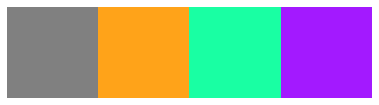

In [663]:
shift = 0.1
s = 0.9
v = 1.0
n = len(clusters)

cluster_to_color = {}
for i in range(n):
    h = (i * (1.0 / n) + shift) % 1.0
    color = colorsys.hsv_to_rgb(h, s, v)
    cluster_to_color.update({i: rgb_string(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))})
    
cluster_to_color.update({-1: 'rgb(128,128,128)'})  # Grey for nodes without a cluster

palette = np.zeros((1, n+1, 3), dtype=np.uint8)
for i in range(-1, n):
    string = cluster_to_color[i]
    r, g, b = rgb(string)
    palette[0, i+1] = np.array([r, g, b])

io.imshow(palette)
plt.axis('off')
plt.show()

In [664]:
json_G = json_graph.node_link_data(G, {'link': 'edges', 'name': 'label'})
nodes = json_G['nodes']
edges = json_G['edges']
id_to_index = {}

i = 0
for node in nodes:
    cluster = node.get('cluster', -1)
    node['x'] = str(layout[node['label']][0])
    node['y'] = str(layout[node['label']][1])
    node['id'] = str(title_to_index[node['label']])  # Note: this ID does not correspond to the ID given by gephi but it doesnt matter
    node['attributes'] = {'cluster': str(cluster)}
    if cluster != -1:
        node.pop('cluster')
    node['color'] = cluster_to_color[cluster]
    node['size'] = 10.0
    id_to_index.update({node['id']: i})
    i += 1
    
i = 0
for edge in edges:
    edge['source'] = str(title_to_index[edge['source']])
    edge['target'] = str(title_to_index[edge['target']])
    edge['id'] = str(i)  # Note: this ID does not correspond to the ID given by gephi but it doesnt matter
    edge['attributes'] = {}
    source_node = nodes[id_to_index[edge['source']]]
    target_node = nodes[id_to_index[edge['target']]]
    r, g, b = merge_colors(source_node['color'], target_node['color'])
    edge['color'] = rgb_string(r, g, b)
    edge['size'] = edge.pop('weight')
    i += 1

In [665]:
nodes[0]

{'label': 'Programmable low-cost DNA-based platform for viral RNA detection',
 'x': '1145.3243270420187',
 'y': '64.15068921432432',
 'id': '5',
 'attributes': {'cluster': '-1'},
 'color': 'rgb(128,128,128)',
 'size': 10.0}

In [666]:
data = {'nodes': nodes, 'edges': edges}

In [667]:
JSON_PATH = 'data/data.json'
with open(JSON_PATH, 'w') as outfile:
    json.dump(data, outfile)

In [668]:
colors = np.zeros((len(nodes), 3), dtype=np.float32)
x = np.zeros((len(nodes),))
y = np.zeros((len(nodes),))
i = 0
for node in nodes:
    r, g, b = rgb(node['color'])
    colors[i] = (r/255., g/255., b/255.)
    x[i] = node['x']
    y[i] = node['y']
    i += 1

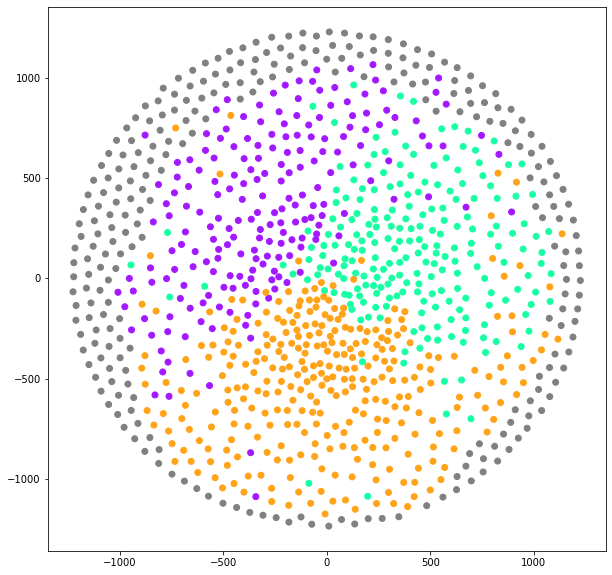

In [669]:
plt.figure(figsize=(10,10))
plt.scatter(x, y, c=colors)
# plt.axis('off')
plt.show()

The end.